# Chapter 16: Reinforcement Learning

_Reinforcement Learning_ (RL) is when a software _agent_ makes _observations_ and takes _actions_ within an _evironment_, and in return it receives _awards_. RL is one of the oldest forms of machine learning, however it was revolutionized when [DeepMind demonstrated that a system could learn to play just about any Atari game](https://arxiv.org/pdf/1312.5602v1.pdf). It could even [outperform humans](https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf) using only the raw pixel values as input without any prior knowledge of the rules of the game. These discoveries eventually led to the victory of their system, AlphaGo, over Ke Jie, the world champion of the game _Go_.

## Policy Search

The goal in RL is to train a system to be able to take actions that it knows will maximize its long term rewards. What actions constitute a positive reward and a negative reward (i.e. an action the system should not take) depends on the particular problem.

The aglorithm an agent uses to determine its next action is called its _policy_. One of the most simple policies is a _stochastic policy_, where the next action is determined entirely by random chance.

_Policy parameters_ are the parameters of the algorithm, an RL system wants to find the policy parameters which lead to the best outcome. Doing so is called a _policy search_ over a _policy space_. The simplest policy search is a brute force search, but if this is not possible, then there are other technqiues:

- _Genetic algorithms_ start by trying out a bunch of random policies, keeping the ones that lead to the best result, then iterating with random augmentations of the best policies to eventually converge to the optimal one.

- Another approach is to evaluate the gradients of the rewards and perform a gradient ascent to the policy that leads to the optimal result. This is called _policy gradients_ and will be discussed later.

## Setting Up

In [0]:
import tensorflow as tf
import numpy as np
import os
import sys

def reset_graph(seed=42):
  tf.reset_default_graph()
  tf.set_random_seed(seed)
  np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Introduction to OpenAI Gym

[OpenAI gym](https://gym.openai.com/) is a toolkit that provides simulated environments for training and developing RL agents.

In [0]:
# Rendering a Ms. Pacman game.

import gym

env = gym.make('MsPacman-v0')

# Initialize the environment with reset()
obs = env.reset()

In [0]:
obs.shape

(210, 160, 3)

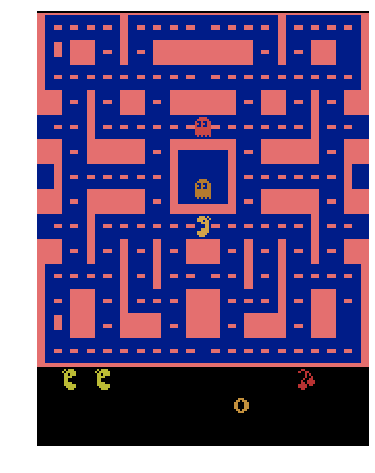

In [0]:
# Plotting the environment

img = env.render(mode='rgb_array')
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [0]:
# In this environment, the image is the same as the entire environment, but in
# other environments this is not always the case.

(img == obs).all()

True

In [0]:
# Utility function for plotting environemnts.

def plot_environment(env, figsize=(10,8)):
  plt.close()
  plt.figure(figsize=figsize)
  img = env.render(mode="rgb_array")
  plt.imshow(img)
  plt.axis("off")
  plt.show()

In [0]:
# The action space has 9 actions, corresponding to the 9 actions you can take
# with the joy stick (8 directions, or remain in center).

env.action_space

Discrete(9)

In [0]:
# Moving the joystick for a number of turns.

env.reset()
for step in range(110):
  env.step(3) # left
for step in range(40):
  env.step(8) # lower-left

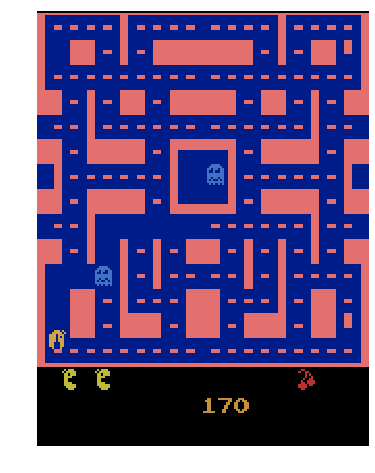

In [0]:
plot_environment(env)

In [0]:
obs, reward, done, info = env.step(0)

In [0]:
# The obs object tells us what the current state looks like, in this
# case it is a 210x160 RGB image.

obs.shape

(210, 160, 3)

In [0]:
# This tells us how much reward the agent has received up to this point.

reward

10.0

In [0]:
# This tells us if the game is over. 

done

False

In [0]:
# This gives us some extra information for debugging. You should not use this
# to train a model.

info

{'ale.lives': 3}

The code below will play a game where it moves the joystick in a different random direction every 10 moves.

In [0]:
# Playing the game with OpenAI Gym.

frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
  img = env.render(mode='rgb_array')
  frames.append(img)
  if step % n_change_steps == 0:
    action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  if done:
    break

In [0]:
# Defining a utility functions for displaying an animation.

from IPython.display import HTML

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
  plt.close()
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch),
                                 frames=len(frames), repeat=repeat,
                                 interval=interval)
  return HTML(anim.to_html5_video())

In [0]:
%matplotlib notebook
plot_animation(frames)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [0]:
# Free the resources used by the environment.

env.close()

## The Cart-Pole environment

The Cart-Pole is a simple environment where a cart that can move left or right and has to balance a pole vertically on its chassis.

In [0]:
env = gym.make('CartPole-v0')
obs = env.reset()
obs

array([-0.04480011, -0.00700969, -0.02022466,  0.00364421])

The 1D numpy array represents the cart's position, it's velocity, the pole's angle, and the pole's angular velocity.

### Fixing a rendering issue

In [0]:
from PIL import Image, ImageDraw

try:
  from pyglet.gl import gl_info
  openai_cart_pole_rendering = True
except Exception:
  openai_cart_pole_rendering = False

def render_cart_pole(env, obs):
  if openai_cart_pole_rendering:
    return env.render(mode='rgb_array')
  img_w = 600
  img_h = 400
  cart_w = img_w // 12
  cart_h = img_h // 15
  pole_len = img_h // 3.5
  pole_w = img_w // 80 + 1
  x_width = 2
  max_ang = 0.2
  bg_color = (255, 255, 255)
  cart_col = 0x000000
  pole_col = 0x669acc

  pos, vel, ang, ang_vel = obs
  img = Image.new('RGB', (img_w, img_h), bg_color)
  draw = ImageDraw.Draw(img)
  cart_x = pos * img_w // x_width + img_w // x_width
  cart_y = img_h * 95 // 100
  top_pole_x = cart_x + pole_len * np.sin(ang)
  top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
  draw.line((0, cart_y, img_w, cart_y), fill=0)

  # Draw the cart.
  draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2,
                  cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col)
  # Draw the pole.
  draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y),
            fill=pole_col, width=pole_w)
  return np.array(img)

def plot_cart_pole(env, obs):
  plt.close()  # or else nbagg sometimes plots in the previous cell
  img = render_cart_pole(env, obs)
  plt.imshow(img)
  plt.axis("off")
  plt.show()

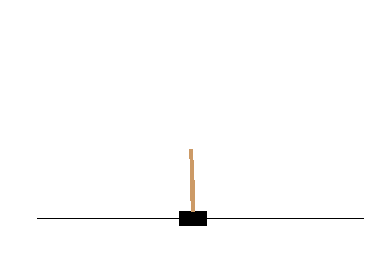

In [0]:
%matplotlib inline
plot_cart_pole(env, obs)

In [0]:
# Looking at the action space.

env.action_space

Discrete(2)

In [0]:
# Let's move the cart left until it falls.

obs = env.reset()
while True:
  obs, reward, done, info = env.step(0)
  if done:
    break

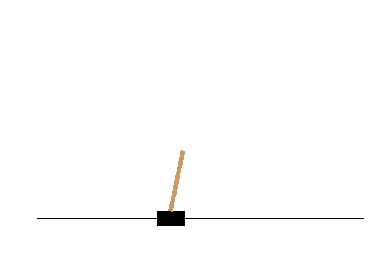

In [0]:
plt.close()
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis('off')
plt.show()

Note that the game is over when the pole tilts a certain amount, not when it falls.

In [0]:
img.shape

(400, 600, 3)

In [0]:
# Now let's have the cart only move to the right.

obs = env.reset()
while True:
  obs, reward, done, info = env.step(1)
  if done:
    break

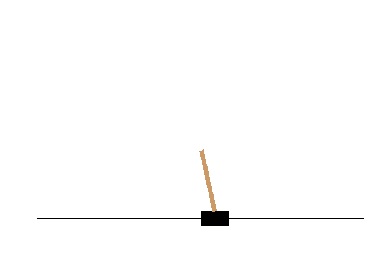

In [0]:
plot_cart_pole(env, obs)

### A simple, hard-coded policy

In order to have the cart keep the pole upright, we must find a policy for the cart which balances the pole. At first, we hard code a simple strategy: if the pole is tilting to the left then the cart will move left, if the pole leans right then the cart moves right.

In [0]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
  img = render_cart_pole(env, obs)
  frames.append(img)

  pos, vel, ang, ang_vel = obs
  action = int(ang >= 0)
  obs, reward, done, info = env.step(action)
  if done:
    break

In [0]:
%matplotlib notebook
plot_animation(frames)

<IPython.core.display.Javascript object>

## Neural Network Policies

Let's create a neural network which will determine the policy for the Cart-Pole agent. Since there are only two actions (go left and go right), the neural network will output one value in the interval [0, 1], representing the probability that the cart goes left.

For this particular problem, the past state of the system can be safely ignored. This is because we get the all of the information about the environment's full state. If we only got the cart's position, we would need to take into account the past states in order to get the cart's velocity. Moreoever if there were noise in the observations, we would need to look at multiple steps to estimate the system's state. The Cart-Pole environment is the simplest possible environment, there is no noise and no hidden state in the previous steps.

In [0]:
n_inputs = 4  # == env.action_space.shape[0]
n_hidden = 4
n_outputs = 1

he_init = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.relu,
                         kernel_initializer=he_init)
outputs = tf.layers.dense(hidden, n_outputs, kernel_initializer=he_init,
                          activation=tf.nn.sigmoid)

p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

init = tf.global_variables_initializer()

You'll notice that the action is determined by taking a multinomial sample using the outputs as probabilities, instead of picking the action with the highest probability. This allows the model to both _explore_ new actions and also _exploit_ actions it knows are good.

Let's initialize the network randomly and play one game.

In [0]:
n_max_steps = 1000
frames = []

with tf.Session() as sess:
  init.run()
  obs = env.reset()
  for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)
    action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
    obs, reward, done, info = env.step(action_val[0][0])
    if done:
      break

env.close()

In [0]:
plot_animation(frames)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The random policy did not perform well. Let's see if we can train the model to learn our previous, hard-coded strategy.

In [0]:
reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
y = tf.placeholder(tf.float32, shape=(None, n_outputs))

learning_rate = 1e-2

he_init = tf.contrib.layers.variance_scaling_initializer()

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=he_init)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)

p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(xentropy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
# Run 10 environments in parallel and train the neural network to use the
# hard-coded policy.

n_environments = 10
n_iterations = 1000

envs = [gym.make('CartPole-v0') for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
  init.run()
  for iteration in range(n_iterations):
    target_probas = \
        np.array([[1.0] if obs[2] < 0 else [0.0] for obs in observations])
    action_val, _ = sess.run([action, training_op],
                             feed_dict={X: np.array(observations),
                                        y: target_probas})
    for idx, env in enumerate(envs):
      obs, reward, done, info = env.step(action_val[idx][0])
      observations[idx] = env.reset() if done else obs
  saver.save(sess, './my_policy_basic.ckpt')

for env in envs:
  env.close()

In [0]:
# Defining a function to show the animation of the Cart-Pole.

def render_policy_net(model_path, action, X, n_max_steps=1000):
  frames = []
  env = gym.make('CartPole-v0')
  obs = env.reset()
  with tf.Session() as sess:
    saver.restore(sess, model_path)
    for step in range(n_max_steps):
      img = render_cart_pole(env, obs)
      frames.append(img)
      action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
      obs, reward, done, info = env.step(action_val[0][0])
      if done:
        break
  env.close()
  return frames

In [0]:
frames = render_policy_net("./my_policy_basic.ckpt", action, X)
plot_animation(frames)

<IPython.core.display.Javascript object>

Looks like the neural network correctly learned the policy.

## Policy Gradients

To train the neural network to learn its own policy, we need to define what the target probabilities are. The neural network should output a high probability for actions that lead to rewards, and a low probability for bad actions. The problem is that it is not possible to see the immediate effects of each action. This is referred to as the _credit assignment problem_.

The _Policy Gradients_ (PG) algorithms optimize the parameters of a policy following the gradients toward higher rewards. Below is a variant of the [REINFORCE algorithms](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf) that was introduced in 1992 by Ronald Williams. It works as follows:

1. First, let the neural network policy play the game several times and at each step compute the gradient that makes the current action more likely, but do not apply it yet.

2. Once you run several episodes, calculate each action's score.

3. Multiply each actions' gradients computed in step 1 by their scores computed in step 2. This reinforces the model to follow good actions and to avoid the negative actions.

4. Compute the mean of all the resulting gradient vectors and use it to perform Gradient Descent.

Below is an implementation of this algorithm using TensorFlow.

In [0]:
# Start defining the model graph.

reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

he_init = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=he_init)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)

p_left_and_right = tf.concat([outputs, 1 - outputs], axis=1)
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

# We want the target probability to be 1 if the action is 0 (move left) and 0
# if the action is 1 (move right).
y = 1 - tf.to_float(action)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)

grads_and_vars = optimizer.compute_gradients(xentropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
  gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
  gradient_placeholders.append(gradient_placeholder)
  grads_and_vars_feed.append((gradient_placeholder, variable))

training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
# Define functions to compute the rewards from each of the possible actions.

def get_discount_rewards(rewards, discount_rate):
  """Compute the cumulative rewards of actions based on their current reward
  and the reward that future actions will bring.

  We multiply future actions by a "discount rate" so that the more short term
  rewards are more valuable than eventual long term rewards.
  
  """
  cumulative_rewards = [None] * len(rewards)
  cumulative_reward = 0.0
  for idx, reward in reversed(list(enumerate(rewards))):
    cumulative_reward = reward + (discount_rate * cumulative_reward)
    cumulative_rewards[idx] = cumulative_reward
  return cumulative_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
  all_discounted_rewards = \
      [get_discount_rewards(rewards, discount_rate) for rewards in all_rewards]
  flat_rewards = np.concatenate(all_discounted_rewards)
  reward_mean = np.mean(flat_rewards)
  reward_stddev = np.std(flat_rewards)
  return [(rewards - reward_mean) / reward_stddev
          for rewards in all_discounted_rewards]

In [0]:
get_discount_rewards([10.0, 0.0, -50.0], discount_rate=0.8)

[-22.0, -40.0, -50.0]

In [0]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [0]:
# Train the model to play the Cart-Pole game.

env = gym.make('CartPole-v0')

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 250
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
  init.run()
  for iteration in range(n_iterations):
    print('\rIteration {}'.format(iteration), end='')
    all_rewards = []
    all_gradients = []
    for game in range(n_games_per_update):
      current_rewards = []
      current_gradients = []
      obs = env.reset()
      for step in range(n_max_steps):
        action_val, gradients_val = \
            sess.run([action, gradients],
                     feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        current_rewards.append(reward)
        current_gradients.append(gradients_val)
        if done:
          break
      all_rewards.append(current_rewards)
      all_gradients.append(current_gradients)

    all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    feed_dict = dict()
    for var_idx, gradient_placeholder in enumerate(gradient_placeholders):
      mean_gradients = np.mean([reward * all_gradients[game_idx][step][var_idx]
                                for game_idx, rewards in enumerate(all_rewards)
                                for step, reward in enumerate(rewards)],
                               axis=0)
      feed_dict[gradient_placeholder] = mean_gradients
    sess.run(training_op, feed_dict=feed_dict)
    if iteration % save_iterations == 0:
      saver.save(sess, "./cart_pole_neural_policy.ckpt")
  saver.save(sess, "./cart_pole_neural_policy.ckpt")

Iteration 249

In [0]:
env.close()

In [0]:
frames = render_policy_net("./cart_pole_neural_policy.ckpt", action, X,
                           n_max_steps=1000)
plot_animation(frames)

<IPython.core.display.Javascript object>

## Markov chains

The mathematician Andrey Markov studied stochastic processes with no memory called _Markcov chains_. Each process has a fixed number of states, and it randomly evolves from one state to another. The probability that the system goes from state $s$ to the state $s'$ depends on the pair $(s, s')$ and is called the _transition probability_. A state that the Markov chain stays falls into and stays in over time is called a _terminal state_.

Below is a some code that runs a simulation of a Markcov chain.

In [0]:
transition_probabilities = [[0.7, 0.2, 0.0, 0.1],
                            [0.0, 0.0, 0.9, 0.1],
                            [0.0, 1.0, 0.0, 0.0],
                            [0.0, 0.0, 0.0, 1.0]]
n_max_steps = 50
terminal_state = 3

def print_sequence(start_state=0):
  curr_state = start_state
  print("States:", end=' ')
  for step in range(n_max_steps):
    print(curr_state, end=' ')
    if curr_state == 3:
      break
    curr_state = np.random.choice(4, p=transition_probabilities[curr_state])
  else:
    print('...', end = ' ')
  print()

for _ in range(10):
  print_sequence()

States: 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 0 0 0 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ... 
States: 0 0 0 0 0 3 
States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 0 0 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ... 
States: 0 0 1 2 1 2 1 2 1 3 


## Markov Decision Processes

_Markov decision processes_ were first described by [Richard Bellman in the 1950s](https://goo.gl/wZTVIN). They resemble Markov chains, except that each state has a discrete number of actions. Each action has a transition probability to the next state.

Below is an example of a Markov decision process where some transitions between states have rewards and punishments (negative reward values). See the book for the graph representation for this process.

In [0]:
transition_probabilities = [
  [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
  [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
  [None, [0.8, 0.1, 0.1], None],
]

rewards = [
  [[10, 0, 0], [0, 0, 0], [0, 0, 0]],
  [[0, 0, 0], None, [0, 0, -50]],
  [None, [40, 0, 0], None],
]

possible_actions = [[0, 1, 2], [0, 2], [1]]

def policy_fire(state):
  """Always try to get the rewarding action at state 0, at state 1 always try
  to transition to state 2 (even though it has negative reward) and at state
  2 there is only one action.

  """
  return [0, 2, 1][state]

def policy_random(state):
  return np.random.choice(possible_actions[state])

def policy_safe(state):
  """
  Always try to avoid any negative reward by always choosing action 0 at
  states 0 and 1.

  """
  return [0, 0, 1][state]

class MDPEvironment(object):
  def __init__(self, start_state=0):
    self.start_state = start_state
    self.reset()

  def reset(self):
    self.total_rewards = 0
    self.state = self.start_state

  def step(self, action):
    next_state = np.random.choice(
        range(3), p=transition_probabilities[self.state][action])
    reward = rewards[self.state][action][next_state]
    self.state = next_state
    self.total_rewards += reward
    return self.state, reward

def run_episode(policy, n_steps, start_state=0, display=True):
  env = MDPEvironment(start_state)
  if display:
    print('States (+rewards):', end=' ')
  for step in range(n_steps):
    if display:
      if step == 10:
        print('...', end = ' ')
      elif step < 10:
        print(env.state, end = ' ')
    action = policy(env.state)
    state, reward = env.step(action)
    if display and step < 10 and reward:
      print('({})'.format(reward), end=' ')
  if display:
    print('Total rewards =', env.total_rewards)
  return env.total_rewards

In [0]:
for policy in (policy_fire, policy_random, policy_safe):
  all_totals = []
  print(policy.__name__)
  for episode in range(100):
    all_totals.append(run_episode(policy, n_steps=100, display=(episode < 5)))
  print('Summary: mean={:.1f} stddev={:.1f} min={:.1f} max={:.1f}'.format(
      np.mean(all_totals), np.std(all_totals), min(all_totals),
      max(all_totals)))
  print()

policy_fire
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 ... Total rewards = 130
States (+rewards): 0 (10) 0 (10) 0 1 (-50) 2 2 2 (40) 0 (10) 0 1 (-50) ... Total rewards = 340
States (+rewards): 0 (10) 0 (10) 0 1 (-50) 2 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 210
States (+rewards): 0 (10) 0 (10) 0 1 (-50) 2 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 180
States (+rewards): 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 1 (-50) ... Total rewards = 140
Summary: mean=132.6 stddev=130.7 min=-150.0 max=510.0

policy_random
States (+rewards): 0 1 1 (-50) 2 (40) 0 0 (10) 0 1 (-50) 2 (40) 0 ... Total rewards = -70
States (+rewards): 0 0 0 0 0 (10) 0 1 (-50) 2 1 (-50) 2 (40) ... Total rewards = -120
States (+rewards): 0 0 (10) 0 (10) 0 0 0 0 (10) 0 0 0 ... Total rewards = -40
States (+rewards): 0 1 (-50) 2 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 ... Total rewards = -30
States (+rewards): 0 1 1 1 1 (-50) 2 1 (-50) 2 (40) 0 0 (10) ... 

Bellman found a way to estimate the _optimal state value_ of any state _s_, i.e. the sum of all the discounted future rewards the agent can expect on average when it reaches state _s_ assuming the agent acts optimally. Bellman showed that if the agent acts optimally, the _Bellman Optimality Equation_ holds:

$$ V^*\left(s\right) = \,\max_a \sum\limits_{s'} T\left(s, a, s'\right) \left[ R\left(s, a, s'\right) + \gamma \cdot V^*\left(s'\right) \right]  \;\; \text{for all } s $$

where

- $T\left(s, a, s'\right)$ is the transition probability from state $s$ to state $s'$ given that the agent takes action $a$.

- $R\left(s, a, s'\right)$ is the reward that the agent gets when it goes from state $s$ to state $s'$ given that the agent takes action $a$.

- $\gamma$ is the discount rate.

This equation directly leads to an algorithm that can estimate the optimal value of every possible state: you first initialize all state value estimates to 0 then you iteratively update them using the _Value Iteration_ algorith, given by:

$$ V_{k+1}\left(s\right) \leftarrow \,\max_a \sum\limits_{s'} T\left(s, a, s'\right) \left[ R\left(s, a, s'\right) + \gamma \cdot V_k\left(s'\right) \right] \;\; \text{for all } s $$

where

- $V_k\left(s\right)$ is the estimated value of the state $s$ at the k<sup>th</sup> iteration of the algorithm.

This algorithm will eventually converge to the optimal state values corresponding to the optimal value. Although knowing the optimal state is helpful, an agent also needs to know what the optimal action it needs to take are. Bellman was able to find a similar algorithm to find the optimal _state-action valuea_, i.e. _Q-Values_. The algorithm is as follows:

$$ Q_{k+1}\left(s, a\right) \leftarrow \,\sum\limits_{s'}\, T\left(s, a, s'\right) \left[ R\left(s, a, s'\right) + \gamma \cdot \max_{a'} Q_k\left(s', a'\right) \right] \;\; \text{for all } (s, a). $$

After computing the Q-Values, defining the optimal policy for each state, $\pi^*(s)$, is simply given by:

$$ \pi^*(s) = \, \underset{a}{\text{argmax}} \; Q^*(s, a). $$

Below is an implementation of the Q-Value Iteration algorithm for the MDP defined above.

In [0]:
n_states = 3
n_actions = 3
n_steps = 100
gamma = 0.95

q_values = np.full((n_states, n_actions), -np.inf)
for state, actions in enumerate(possible_actions):
  q_values[state, actions] = 0

for step in range(n_steps):
  q_prev = q_values.copy()
  for s in range(3):
    for a in possible_actions[s]:
      q_values[s, a] = np.sum([
        transition_probabilities[s][a][sp] * \
            (rewards[s][a][sp] + gamma * np.max(q_prev[sp]))
        for sp in range(3)
      ])

In [0]:
q_values

array([[21.88646117, 20.79149867, 16.854807  ],
       [ 1.10804034,        -inf,  1.16703135],
       [       -inf, 53.8607061 ,        -inf]])

## Temporal Difference and Q-Learning

RL problems with discrete actions can be modeled as MDPs, however the model often does not know the transition probabilities, $T\left(s,a,s'\right)$, or the rewards of each action, $R\left(s,a,s'\right)$. The _Temporal Difference Learning_ (TD Learning) algorithm is similar to the Value Iteration algorithm, only it is changed to account for the fact that the model does not know the transition probabilities or rewards. Instead the model uses an _exploration policy_ to explore the MDP and learn the transition probabilites and rewards. The TD Learning algorithm is given by

$$ V_{k+1}(s) \leftarrow \, (1 - \alpha) \cdot V_k(s) \, + \, \alpha \left(r + \gamma \cdot V_k\left(s'\right) \right) $$

where $\alpha$ is the learning rate (e.g. 0.01). Similarly, the Q-Learning algorithm is an alternate form of the Q-Value Iteration algorithm where the transition probabilities and rewards are initially unknown. The algorithm is given by

$$ Q_{k+1}(s, a) \leftarrow \, (1-\alpha)\cdot Q_k(s,a) \, + \, \alpha\left( r + \gamma \cdot \max_{a'} \, Q_k\left(s',a'\right) \right). $$

Below is an implementation of the Q-Learning algorithm using the MDP defined above.

In [0]:
n_states = 3
n_actions = 3
n_steps = 20000
alpha = 0.01
gamma = 0.99
exploration_policy = policy_random

q_values = np.full((n_states, n_actions), -np.inf)
for state, actions in enumerate(possible_actions):
  q_values[state, actions] = 0

env = MDPEvironment()
for step in range(n_steps):
  action = exploration_policy(env.state)
  state = env.state
  next_state, reward = env.step(action)
  next_value = np.max(q_values[next_state])
  q_values[state, action] *= 1 - alpha
  q_values[state, action] += alpha * (reward + (gamma * next_value))

In [0]:
def optimal_policy(q_values, state):
    return np.argmax(q_values[state])

In [0]:
q_values

array([[50.18438023, 50.42564591, 46.50027022],
       [29.50600142,        -inf, 30.94171103],
       [       -inf, 83.87592904,        -inf]])

The Q-Learning algorithm is an example of an _off-policy_ algorithm since the algorithm being trained will not be the one executed after training is complete.

### Approximate Q-Learning and Deep Q-Learning

Since Q-Learning does not scale well to MDPs which have a large number of states, we need to find a function $Q_\theta(s, a)$ which approximates the Q-Value of the state-action pair $(s,a)$.

DeepMind was able to show that using a deep neural network can estimate the Q-Values for complex problems and it does not require feature engineering. A DNN used to estimate Q-Values is called a _deep Q-network_ (DQN), and using a DQN for Approximate Q-Learning is called _Deep Q-Learning_.

In order to train the DQN, we first must find a way to compute what the target Q-Values should be. Thanks to Bellman, we know the if a state-action pair $(s,a)$ plus the discounted value of playing optimally from then on. To get the approximate Q-Values of future actions, we just run the DQN for those future state-action pairs. The target Q-Value will be given by

$$ y(s, a) = r + \gamma\cdot \max_{a'}\, Q_{\,\theta}\left(s',a'\right). $$

Using these target values, we can train a model using Gradient Descent trying to minimize the MSE between the estimated Q-Value and the target Q-Value.

It's important to note that DeepMind's algorithm differed in two crucial ways:

- DeepMind's DQN stores experiences in a large _replay memory_ and randomly samples a training batch of its past experiences for each training iteration. This reduces correlation between experiences in a training batch which improves performance.

- The algorithm uses two DQNs: the first is called the _online DQN_ and is the one that plays and learns at each training iteration. The second is called the _target DQN_, and it is only used to compare the target Q-Values. At regular intervals, the parameters of the online DQN are copied to the target DQN. This prevents feedback looks which can cause gradients to diverge.

## Learning to Play Ms. Pac-Man Using the DQN Algorithm

See `MsPacMan.ipynb` for an example of training a DQN.

## Extra Material

### Preprocessing for Breakout

Below is a simple preprocessing function for training a DQN for the Breakout-v0 Atari game:

In [0]:
def preprocess_observation(obs):
  img = obs[34:194:2, ::2] # crop and downsize
  return np.mean(img, axis=2).reshape(80, 80) / 255

In [0]:
env = gym.make('Breakout-v0')
obs = env.reset()
for _ in range(10):
  obs, _, _, _ = env.step(1)

img = preprocess_observation(obs)

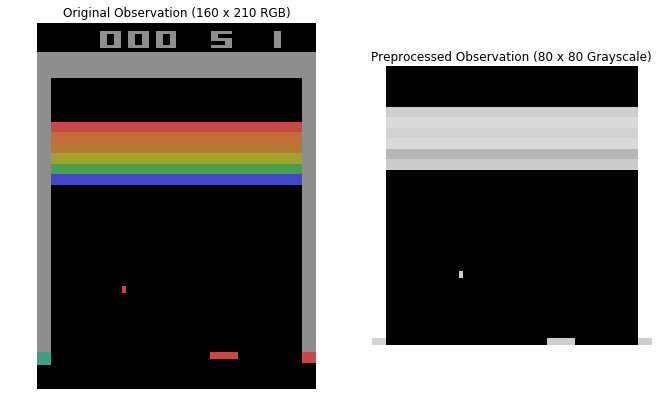

In [8]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title('Original Observation (160 x 210 RGB)')
plt.imshow(obs)
plt.axis('off')
plt.subplot(122)
plt.title('Preprocessed Observation (80 x 80 Grayscale)')
plt.imshow(img, interpolation='nearest', cmap='gray')
plt.axis('off')
plt.show()

As you can see, the single image does not give information about the ball's velocity, which is crucial information for an agent playing this game. For this reason, it's best to combine several consecutive observations to create an accurate representation of the environment's state. One way to do this is create a multi-channel image with one channel per recent observation. Another is to merge all recent observations into a single channel image using `np.max()`. In this case, we also need to dim the older images so that a DQN can distinguish the past from the present.

In [0]:
from collections import deque

def combine_observations_multichannel(preprocess_observations):
  return np.array(preprocess_observations).transpose([1, 2, 0])

def combine_observations_singlechannel(preprocess_observations, dim_factor=0.5):
  dimmed = [obs * (dim_factor ** idx)
            for idx, obs in enumerate(reversed(preprocess_observations))]
  return np.max(np.array(dimmed), axis=0)

In [0]:
n_observations_per_state = 3
preprocess_observations = deque([], maxlen=n_observations_per_state)

obs = env.reset()
for _ in range(10):
  obs, _, _, _ = env.step(1)
  preprocess_observations.append(preprocess_observation(obs))

In [0]:
img1 = combine_observations_multichannel(preprocess_observations)
img2 = combine_observations_singlechannel(preprocess_observations)

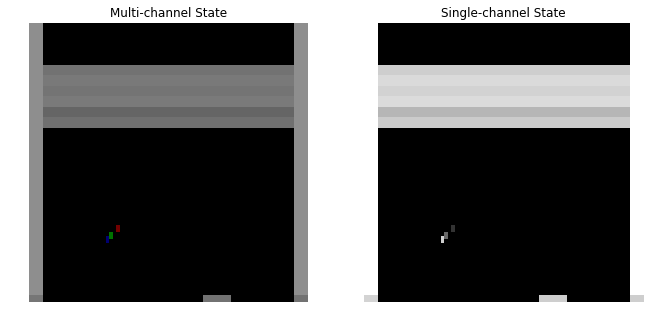

In [12]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title('Multi-channel State')
plt.imshow(img1, interpolation='nearest')
plt.axis('off')
plt.subplot(122)
plt.title('Single-channel State')
plt.imshow(img2, interpolation='nearest', cmap='gray')
plt.axis('off')
plt.show()

## Exercises

See `Exercises.ipynb` for exercise solutions for Chapter 16.